# ARIMA 모델로 주가 예측하기<span class="tocSkip">

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-시계열-데이터-준비" data-toc-modified-id="1.-시계열-데이터-준비-1">1. 시계열 데이터 준비</a></span></li><li><span><a href="#2.-시계열-안정성-분석" data-toc-modified-id="2.-시계열-안정성-분석-2">2. 시계열 안정성 분석</a></span></li><li><span><a href="#3.-학습,-테스트-데이터셋-생성" data-toc-modified-id="3.-학습,-테스트-데이터셋-생성-3">3. 학습, 테스트 데이터셋 생성</a></span></li><li><span><a href="#4.-적정-ARIMA-모수-찾기" data-toc-modified-id="4.-적정-ARIMA-모수-찾기-4">4. 적정 ARIMA 모수 찾기</a></span></li><li><span><a href="#5.-ARIMA-모델-훈련과-테스트" data-toc-modified-id="5.-ARIMA-모델-훈련과-테스트-5">5. ARIMA 모델 훈련과 테스트</a></span></li><li><span><a href="#6.-반복" data-toc-modified-id="6.-반복-6">6. 반복</a></span></li></ul></div>

# 1. 시계열 데이터 준비
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Time Series 생성
def 생성(filename):
    dataset_dirpath = os.getenv('HOME') + '/aiffel/stock_prediction/data'
    dataset_filepath = os.path.join(dataset_dirpath, filename)
    df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
    ts = df['Close']

    ts.head()
    # 결측치 처리
    ts = ts.interpolate(method='time')
    ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.
    # 로그 변환
    global ts_log
    ts_log = np.log(ts)
    return ts_log
생성("K.csv")

Date
2020-09-08    4.194793
2020-09-09    4.197653
2020-09-10    4.189655
2020-09-11    4.181134
2020-09-14    4.180828
                ...   
2021-08-30    4.145671
2021-08-31    4.145354
2021-09-01    4.147727
2021-09-02    4.150410
2021-09-03    4.150095
Name: Close, Length: 251, dtype: float64

# 2. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

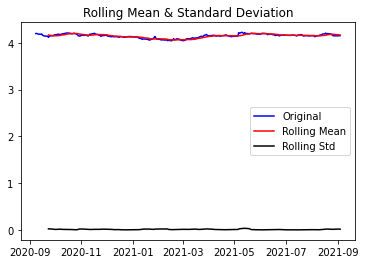

In [2]:
# 정성적 그래프 분석
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
plot_rolling_statistics(ts_log, window=12)

In [3]:
#정량적 Augmented Dicky-Fuller Test
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.426614
p-value                          0.134365
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


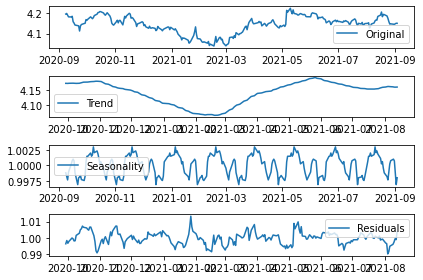

In [4]:
#시계열 분해 (Time Series Decomposition)
def 분해():
    decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    global residual
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
분해()

In [5]:
# Residual 안정성 확인
def 확인():
    residual.dropna(inplace=True)
    augmented_dickey_fuller_test(residual)
확인()

Results of Dickey-Fuller Test:
Test Statistic                -6.009290e+00
p-value                        1.587639e-07
#Lags Used                     1.100000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


# 3. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

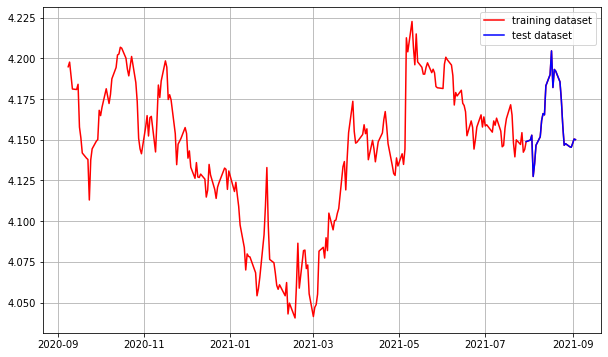

In [6]:
def 분리():
    global train_data
    global test_data
    train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
    plt.plot(test_data, c='b', label='test dataset')
    plt.legend()
분리()

# 4. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

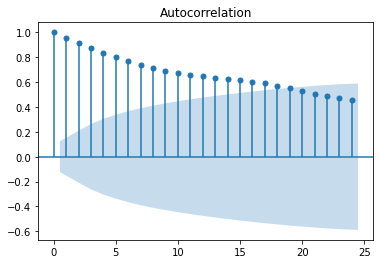

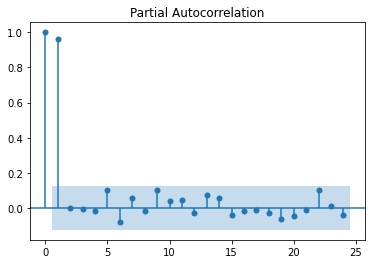

In [7]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def 그리기():
    plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
    plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
    plt.show()
그리기()

Results of Dickey-Fuller Test:
Test Statistic                -1.612719e+01
p-value                        4.827946e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


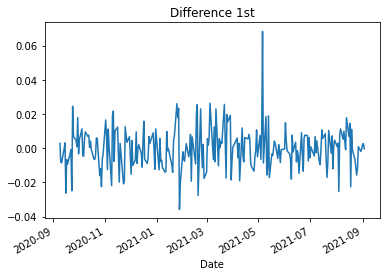

In [8]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
def 구하기1():
    global diff_1
    diff_1 = ts_log.diff(periods=1).iloc[1:]
    diff_1.plot(title='Difference 1st')

    augmented_dickey_fuller_test(diff_1)
구하기1()

Results of Dickey-Fuller Test:
Test Statistic                -7.239450e+00
p-value                        1.901201e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


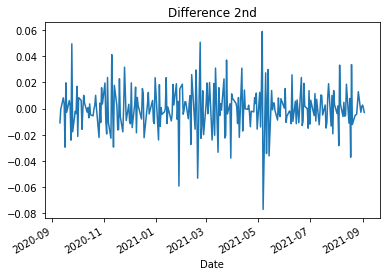

In [9]:
# 혹시 필요한 경우 2차 차분 구하기
def 구하기2():
    global diff_2
    diff_2 = diff_1.diff(periods=1).iloc[1:]
    diff_2.plot(title='Difference 2nd')

    augmented_dickey_fuller_test(diff_2)
구하기2()

# 5. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [10]:
from statsmodels.tsa.arima_model import ARIMA
# Build and Train  Model
def 모델(p,d,q):
    model = ARIMA(train_data, order=(p,d,q))  
    global fitted_m
    fitted_m = model.fit(disp=-1)
    print(fitted_m.summary())
모델(1,1,2)
# q가 0일때보다 2일때 MAPE가 더 낮음.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 674.312
Method:                       css-mle   S.D. of innovations              0.012
Date:                Tue, 07 Sep 2021   AIC                          -1338.624
Time:                        12:37:40   BIC                          -1321.566
Sample:                             1   HQIC                         -1331.739
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.001     -0.292      0.770      -0.002       0.001
ar.L1.D.Close    -0.8089      0.108     -7.519      0.000      -1.020      -0.598
ma.L1.D.Close     0.7988      0.122     

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


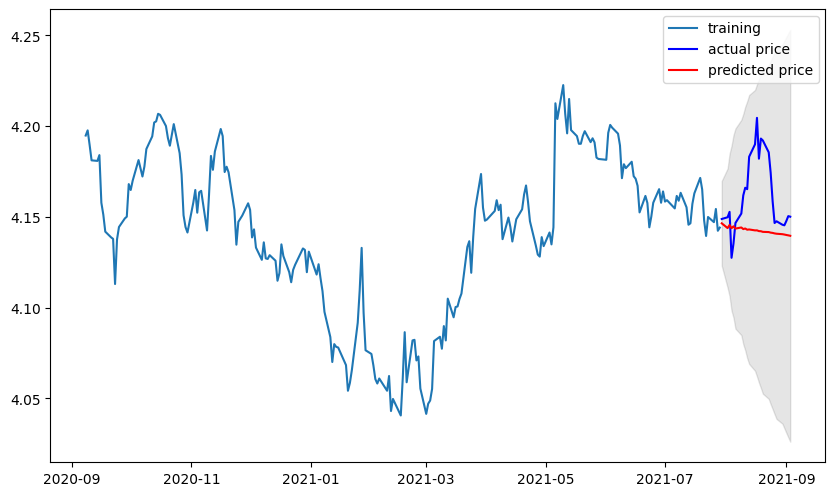

In [11]:
def 결과():
    # Forecast : 결과가 fc에 담깁니다. 
    global fc, se, conf
    fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
    lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
    upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

    # Plot
    plt.figure(figsize=(10,6), dpi=100)
    plt.plot(train_data, label='training')
    plt.plot(test_data, c='b', label='actual price')
    plt.plot(fc_series, c='r',label='predicted price')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
    plt.legend()
    plt.show()
결과()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

def 분석():
    mse = mean_squared_error(np.exp(test_data), np.exp(fc))
    print('MSE: ', mse)

    mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
    print('MAE: ', mae)

    rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
    print('RMSE: ', rmse)

    mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
    print('MAPE: {:.2f}%'.format(mape*100))
분석()

MSE:  3.1896706215154498
MAE:  1.3603360982128834
RMSE:  1.785964899295462
MAPE: 2.09%


# 6. 반복

In [13]:
생성("GOOG.csv")

Date
2020-09-08    7.334584
2020-09-09    7.350490
2020-09-10    7.334342
2020-09-11    7.326939
2020-09-14    7.325992
                ...   
2021-08-30    7.975699
2021-08-31    7.975647
2021-09-01    7.978256
2021-09-02    7.967065
2021-09-03    7.970913
Name: Close, Length: 251, dtype: float64

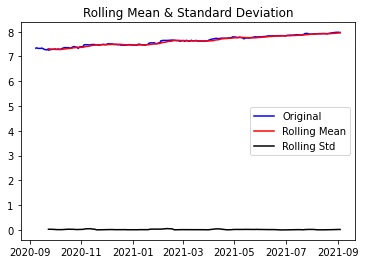

In [14]:
plot_rolling_statistics(ts_log, window=12)

In [15]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -0.460093
p-value                          0.899572
#Lags Used                       7.000000
Number of Observations Used    243.000000
Critical Value (1%)             -3.457551
Critical Value (5%)             -2.873509
Critical Value (10%)            -2.573148
dtype: float64


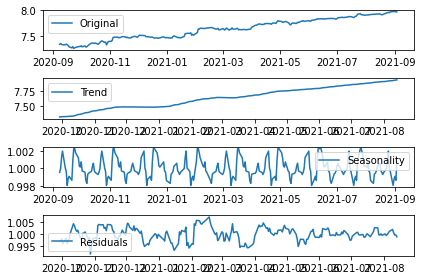

In [16]:
분해()

In [17]:
확인()

Results of Dickey-Fuller Test:
Test Statistic                  -2.754986
p-value                          0.064997
#Lags Used                      15.000000
Number of Observations Used    205.000000
Critical Value (1%)             -3.462658
Critical Value (5%)             -2.875744
Critical Value (10%)            -2.574341
dtype: float64


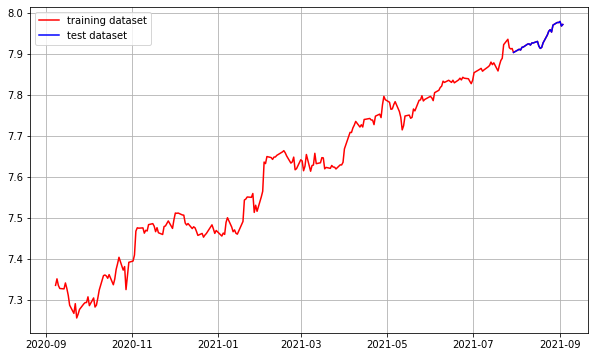

In [18]:
분리()

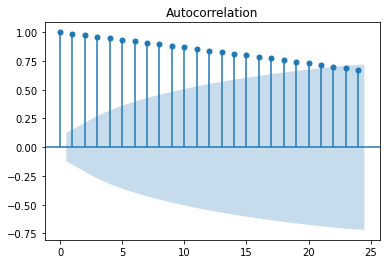

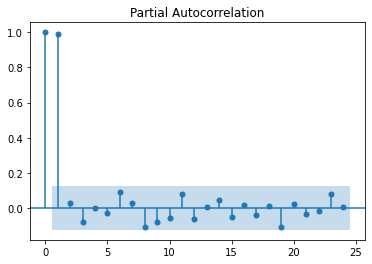

In [19]:
그리기()

Results of Dickey-Fuller Test:
Test Statistic                -6.586295e+00
p-value                        7.300537e-09
#Lags Used                     6.000000e+00
Number of Observations Used    2.430000e+02
Critical Value (1%)           -3.457551e+00
Critical Value (5%)           -2.873509e+00
Critical Value (10%)          -2.573148e+00
dtype: float64


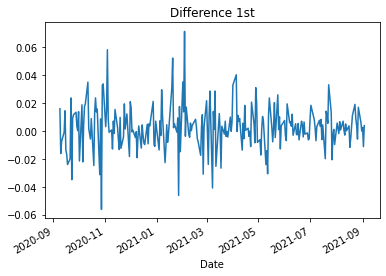

In [20]:
구하기1()

Results of Dickey-Fuller Test:
Test Statistic                -6.930959e+00
p-value                        1.084448e-09
#Lags Used                     1.600000e+01
Number of Observations Used    2.320000e+02
Critical Value (1%)           -3.458855e+00
Critical Value (5%)           -2.874080e+00
Critical Value (10%)          -2.573453e+00
dtype: float64


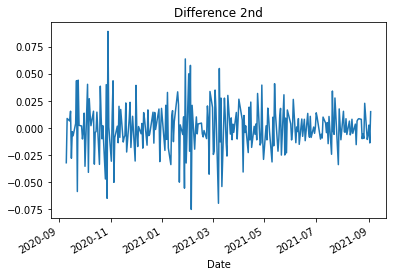

In [21]:
구하기2()

In [22]:
모델(1,1,0)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 603.369
Method:                       css-mle   S.D. of innovations              0.016
Date:                Tue, 07 Sep 2021   AIC                          -1200.738
Time:                        12:37:42   BIC                          -1190.503
Sample:                             1   HQIC                         -1196.606
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0026      0.001      2.464      0.014       0.001       0.005
ar.L1.D.Close    -0.0455      0.067     -0.683      0.495      -0.176       0.085
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

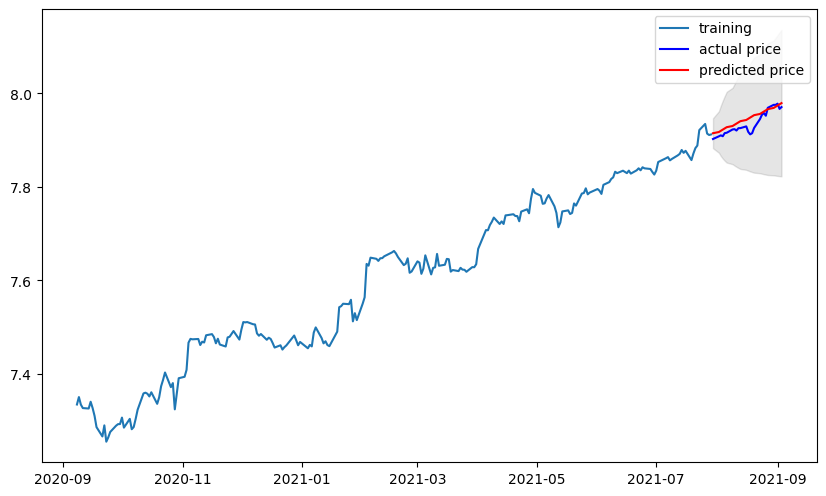

In [23]:
결과()

In [24]:
분석()

MSE:  1904.1269051311667
MAE:  35.83070718588424
RMSE:  43.63630260610042
MAPE: 1.29%


In [25]:
생성("HPE.csv")

Date
2020-09-08    2.243896
2020-09-09    2.247072
2020-09-10    2.221375
2020-09-11    2.223542
2020-09-14    2.237513
                ...   
2021-08-30    2.728506
2021-08-31    2.738256
2021-09-01    2.730464
2021-09-02    2.733718
2021-09-03    2.739549
Name: Close, Length: 251, dtype: float64

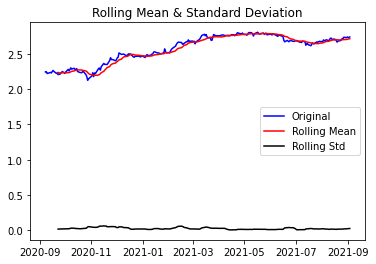

In [26]:
plot_rolling_statistics(ts_log, window=12)

In [27]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.431732
p-value                          0.566972
#Lags Used                       0.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64


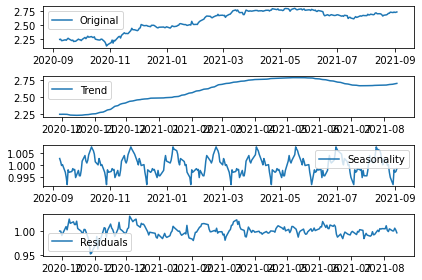

In [28]:
분해()

In [29]:
확인()

Results of Dickey-Fuller Test:
Test Statistic                  -5.344454
p-value                          0.000004
#Lags Used                       7.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


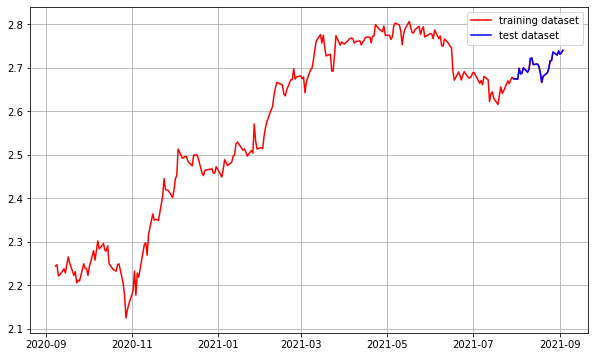

In [30]:
분리()

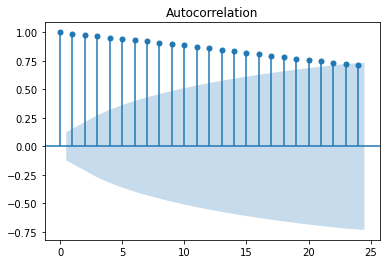

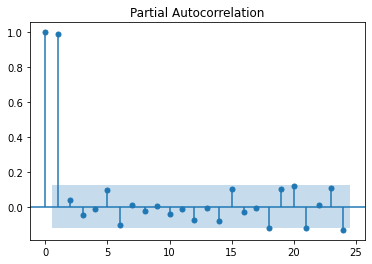

In [31]:
그리기()

Results of Dickey-Fuller Test:
Test Statistic                -1.682279e+01
p-value                        1.174646e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


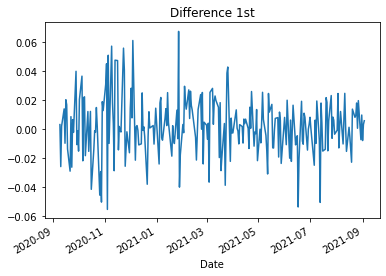

In [32]:
구하기1()

Results of Dickey-Fuller Test:
Test Statistic                -8.614429e+00
p-value                        6.346731e-14
#Lags Used                     9.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


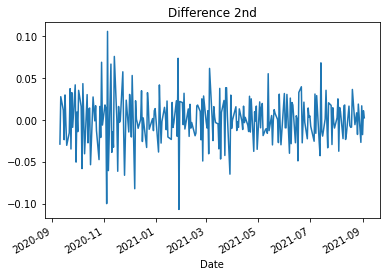

In [33]:
구하기2()

In [34]:
모델(1,1,0)
# d가 2일때보다 1일때가 나음.

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 552.943
Method:                       css-mle   S.D. of innovations              0.020
Date:                Tue, 07 Sep 2021   AIC                          -1099.885
Time:                        12:37:44   BIC                          -1089.650
Sample:                             1   HQIC                         -1095.754
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.001      1.506      0.132      -0.001       0.004
ar.L1.D.Close    -0.0667      0.067     -1.002      0.316      -0.197       0.064
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency informa

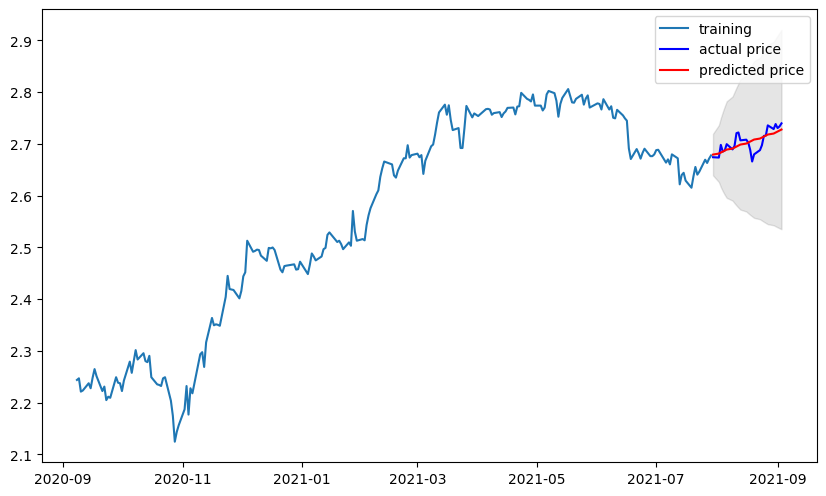

In [35]:
결과()

In [36]:
분석()

MSE:  0.05294403216688055
MAE:  0.1742095119488824
RMSE:  0.23009570219124162
MAPE: 1.17%


루브릭  
1 - def augmented_dickey_fuller_test(timeseries):에서 adfuller사용함.  
2 - 그리기와 구하기 함수  
3 - MAPE는 1~2%대

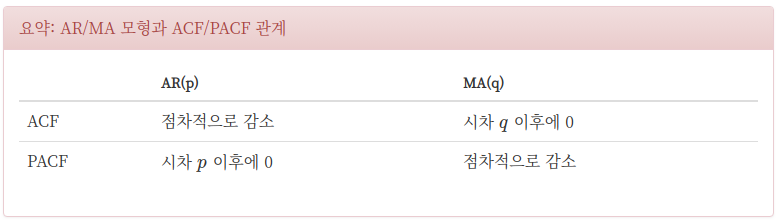
PACF가 0이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.
반면 ACF는 점차적으로 감소하고 있어서 AR(1) 모델에 유사한 형태를 보이고 있습니다. q에 대해서는 적합한 값이 없어 보입니다. MA를 고려할 필요가 없다면 q=0으로 둘 수 있습니다.